## MyConnectome analyses

In this notebook we will examine various analyses of the resting fMRI data from the MyConnectome study.  

### Predicting mood and fatigue from resting connectivity

After each resting scan, the subject completed a Positive and Negative Affect Scale (PANAS) which provides measures of positive and negative mood and fatigue.  In this exercise we will attempt to predict mood measures from functional connectivity estimated from resting fMRI. The fmri data were first projected onto the surface and then averaged within a set of 616 cortical regions identified using surface-based parcellation, as well as 14 subcortical regions.  The mean fMRI signal was then extracted from each of those regions for each time point.  See Laumann et al. (2015, *Neuron*) for more details on data processing.  Using these timseries, functional connectivity was estimated between each of these pairs of regions using Pearson correlation, giving a total of 198135 connections.  

In this example we will use ridge regression to examine whether mood and fatigue ratings can be predicted from functional connectivity measures.

In [133]:
import os
import numpy
import pandas
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import explained_variance_score,mean_absolute_error
import nilearn.plotting

import cairocffi # needed for igraph plotting on Mac
import igraph

from get_balanced_folds import BalancedKFold

# if data don't exist then download them
if not os.path.exists('data'):
    # download the data
    import requests,tarfile
    print('no data directory, downloading the data...')
    url = "http://web.stanford.edu/group/poldracklab/myconnectome-example/data.tgz"
    filename = url.split("/")[-1]
    with open(filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
    print('unpacking data.tgz')
    file = tarfile.open('data.tgz', 'r:gz')
    file.extractall()
    file.close()
    os.remove('data.tgz')

# set this to the location of the datafiles on your system - if automatically downloaded then it will be "./data"
datadir='data'
assert os.path.exists(datadir)

# load the correlation data. This matrix contains
# the upper triangle of the correlation matrix between each of the 630
# regions, across each of the 84 good sessions
corrdata=numpy.load(os.path.join(datadir,'rsfmri/corrdata.npy'))
meancorr=numpy.mean(corrdata,0)

# load the behavioral data, which includes the PANAS scores
behavdata=pandas.read_csv(os.path.join(datadir,'trackingdata_goodscans.txt'),
                         header=0,sep='\t',na_values='.')
# reduce to the three variables that we will work with
behavdata=behavdata[['panas:positive','panas:negative','panas:fatigue']]

# load information about the regions (which we call "parcels")
parceldata=pandas.read_csv(os.path.join(datadir,'parcel_data.txt'),
                          header=None,sep='\t')
parceldata.replace(to_replace='na', value='Subcortical', inplace=True)
parceldata.replace(to_replace='Zero', value='Unassigned', inplace=True)
parceldata.columns=['num','hemis','X','Y','Z','lobe','sublobe',
                    'power','yeo7','yeo17']


# The data are stored as upper triangle, but we need to put them back into
# a matrix for some operations, so we create a utility function
# to do this
def mtx_from_utr(utr,complete=True):
    """
    create full weight matrix from upper triangle, taking mean across first axis
    complete: should bottom triangle be completed as well?
    """
    mtx=numpy.zeros((630,630))
    if len(utr.shape)>1:
        mtx[numpy.triu_indices_from(mtx,1)]=utr.mean(axis=0)
    else:
        mtx[numpy.triu_indices_from(mtx,1)]=utr
       
    if complete:
        mtx=mtx+mtx.T
    return(mtx)

#  make mean correlation matrix
meancorrmtx=mtx_from_utr(corrdata)

Now let's create a function that will predict panas scores from connectivity matrices.  Here we use a special crossvalidation operator that implements balanced cross validation for continuous variables, which basically ensures that every crossvalidation fold has a roughly similar distribution on the Y variable.  If we don't do this, then we could end up with negative correlations between predicted and actual values under the null hypothesis (see http://www.russpoldrack.org/2012/12/the-perils-of-leave-one-out.html and http://not2hastie.tumblr.com/).  We will compute two measures of prediction accuracy: variance explained between predicted and actual ratings (which provides an interpretable measure of model fit), and mean absolute error (which may be more relevant if our goal is prediction of precise values).

In [62]:
def panas_predict(Yvar,behavdata,corrdata,
                  shuffle=False,
                  n_splits=20,
                  clf=Ridge(alpha=0.01),
                  cv=BalancedKFold(),
                  scaler=StandardScaler(),
                  return_weights=False,
                  print_results=True,
                  scale_Y=True):
    """
    run prediction analysis on panas data
    Yvar: name of Y variable
    shuffle: if  True, then the Y values will be randomly shuffled on each round
    scaler: set to None to turn off scaling
    scale_Y: scale the Y variable so that MAE is in z-score units
    """
    # remove session with missing values for Y variable
    goodY=numpy.isfinite(behavdata[Yvar].values)
    Y=behavdata[Yvar].values[goodY]
    if scale_Y:
        Y=scaler.fit_transform(Y[:,numpy.newaxis])[:,0]
        unitstring=' (z-score units)'
    else:
        unitstring=''
    X=corrdata[goodY,:]
    
    # create output variables
    explained_var=numpy.zeros(n_splits) 
    meanabserr=numpy.zeros(n_splits) 
    mean_weights=numpy.zeros((n_splits,corrdata.shape[1]))
    
    # loop through multiple random splits
    # to ensure that any results are not due to particular split
    for i in range(n_splits):
        weights=numpy.zeros((cv.nfolds,corrdata.shape[1])) # save weights for this run
        if shuffle:
            numpy.random.shuffle(Y)
        pred=numpy.zeros(X.shape[0]) # to store predictions
        cvctr=0
        for train_index, test_index in cv.split(X,Y):            
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scaler is not None:
                # learn the scaler from training data
                X_train=scaler.fit_transform(X_train)
                # apply scaler to test data
                X_test=scaler.transform(X_test)

            clf.fit(X_train,y_train)
            if hasattr(clf,'coef_'):
                weights[cvctr,:]=clf.coef_
                cvctr+=1
            pred[test_index]=clf.predict(X_test)
            
        mean_weights[i,:]=weights.mean(axis=0)
        explained_var[i]=explained_variance_score(Y,pred)
        meanabserr[i]=mean_absolute_error(Y,pred)
    
    print('Prediction analysis for',Yvar)
    if shuffle:
        print('with shuffled Y values: ')
    print('Mean explained variance (+/- SD):',explained_var.mean(),explained_var.std())
    print('Mean MAE%s (+/- SD):'%unitstring,meanabserr.mean(),meanabserr.std())

    if return_weights:
        return(explained_var,meanabserr,mean_weights)
    else:
        return(explained_var,meanabserr)


In [63]:
# run it once with positive affect data

rsquared,meanabserr=panas_predict('panas:positive',behavdata,corrdata)


Prediction analysis for panas:positive
Mean explained variance (+/- SD): 0.124767404897 0.0405235669897
Mean MAE (z-score units) (+/- SD): 0.771406823563 0.017110202837


In [64]:
# run with shuffled data
# in reality we would want to rerun the permuted version many more times
# to compute a realistic null distribution

rsquared,meanabserr=panas_predict('panas:positive',behavdata,corrdata,
                                  shuffle=True)


Prediction analysis for panas:positive
with shuffled Y values: 
Mean explained variance (+/- SD): -0.134432940425 0.120267839537
Mean MAE (z-score units) (+/- SD): 0.845255491585 0.0471085153303


Now let's try it for the other variables

In [5]:
rsquared,meanabserr=panas_predict('panas:negative',behavdata,corrdata)


Mean rsquared (+/- SD): 0.011543646826 0.0115665904548
Mean absolute error (+/- SD): 2.01383010475 0.0503395034401


In [65]:
rsquared,meanabserr,weights=panas_predict('panas:fatigue',behavdata,corrdata,
                      return_weights=True)
rsquared,meanabserr=panas_predict('panas:fatigue',behavdata,corrdata,
                      shuffle=True)


Prediction analysis for panas:fatigue
Mean explained variance (+/- SD): 0.266367086633 0.0373832501873
Mean MAE (z-score units) (+/- SD): 0.687213529206 0.0202134474747
Prediction analysis for panas:fatigue
with shuffled Y values: 
Mean explained variance (+/- SD): -0.114704283684 0.127201135727
Mean MAE (z-score units) (+/- SD): 0.793035239367 0.043457149267


### Visualizing classifier weights

It appears that fatigue is strongly predictable from connectivity.  Let's dig in a bit further to find out what specific connections or networks are driving this. First let's choose the most strongly weighted edges from the classifier and visualize those.


Now we can plot the weight matrix using nilearn's plot_connectome function; we will threshold the weights to show the top 0.1%.  First we need to transform it back to a full matrix from the upper triangle.

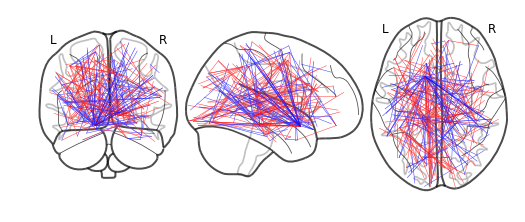

In [8]:
# use nilearn's plot_connectome function to visualize the weights
weight_mtx=mtx_from_utr(weights)
nilearn.plotting.plot_connectome(weight_mtx, parceldata.iloc[:,2:5],
                                edge_threshold='99.9%',
                                node_size=0,
                                edge_kwargs={'linewidth':0.5})


As you can see, it's somewhat difficult to discern much by looking at the connections projected using orthogonal sections. Another alternative is to use the fact that function connectivity can be characterized in terms of a much smaller number of large-scale networks, and summarize the weights in terms of within- and between-network connectivity.

In the myconnectome data we already have a set of network assignments (based on the earlier work of Power et al) so let's start with those.  First let's visualize the networks by sorting the mean correlation matrix by network.

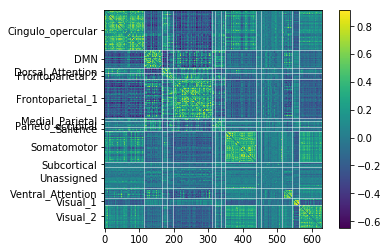

In [25]:
def reorder_corrs(corrmtx,parceldata,labels='power'):
    """
    reorder correlation matrix according to network labels
    """
    idx=numpy.argsort(parceldata[labels])
    tmp=corrmtx[:,idx]
    return(tmp[idx,:],parceldata.iloc[idx,:])

def plot_reordered_corrs(corrmtx,parceldata,labels='power'):
    """
    plot correlation matrix after reordering
    """

    corr_reord,parceldata_reord=reorder_corrs(corrmtx,parceldata,labels)
    plt.imshow(corr_reord)
    # find breakpoints and plot lines
    breaks=numpy.array([int(not i) for i in parceldata_reord[labels].values[:-1]==parceldata_reord[labels].values[1:]])
    breaklocs=numpy.where(breaks)[0]
    for b in breaklocs:
        plt.plot([0,corrmtx.shape[0]-1],[b,b],color='w',linewidth=0.5)
        plt.plot([b,b],[0,corrmtx.shape[0]-1],color='w',linewidth=0.5)
    # find label locations
    # add a zero to help find label locations 
    breaklocs=numpy.hstack((breaklocs,[len(breaks)]))
    breaklocs2=numpy.hstack(([0],breaklocs))
    label_locs=numpy.mean(numpy.vstack((breaklocs,breaklocs2[:-1])),0)
    networks=parceldata_reord['power'].values[breaklocs]
    ax=plt.gca()
    ax.set_yticks(label_locs)
    ax.set_yticklabels(networks)
    plt.colorbar()

plot_reordered_corrs(meancorrmtx,parceldata)

We can also visualize the networks projected into the 3-d space of the brain, using nilearn's plot_connectome() function.

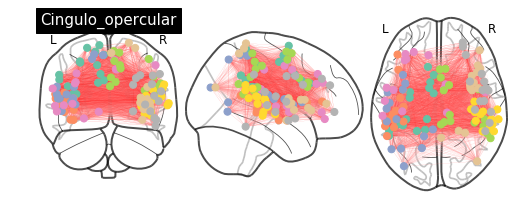

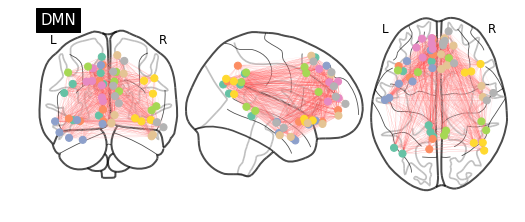

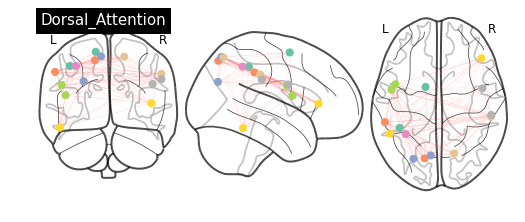

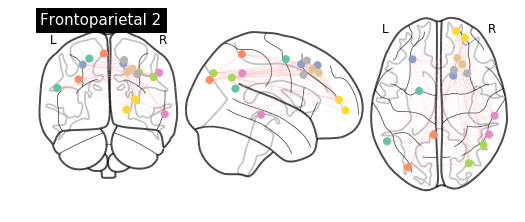

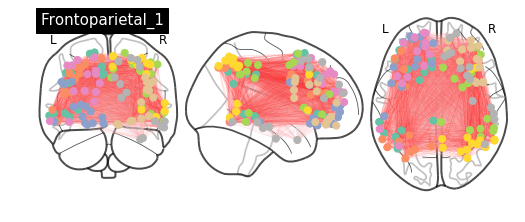

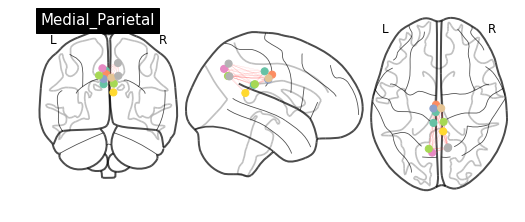

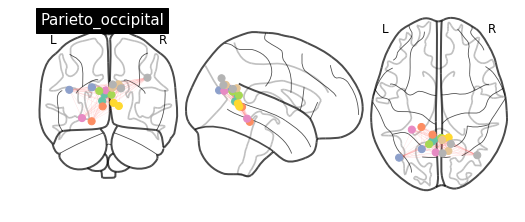

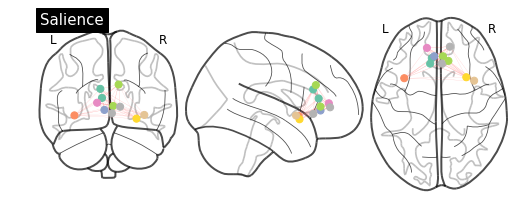

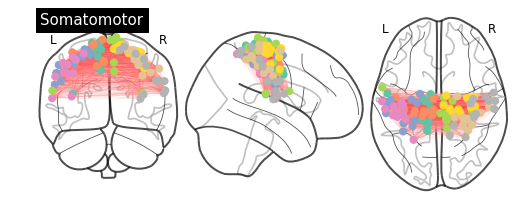

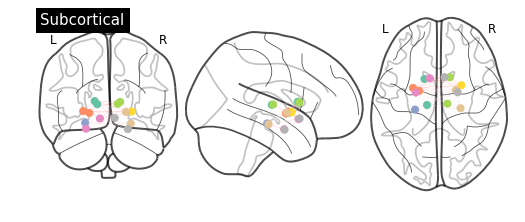

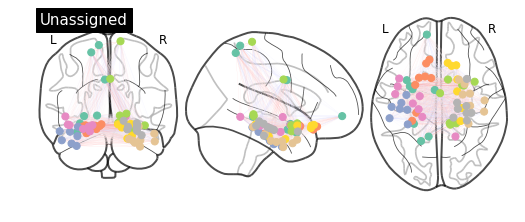

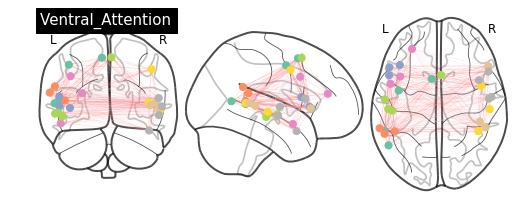

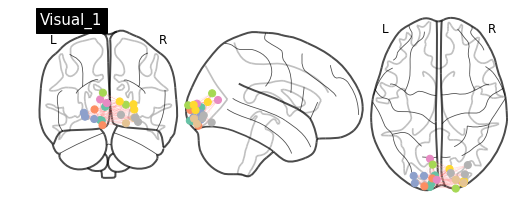

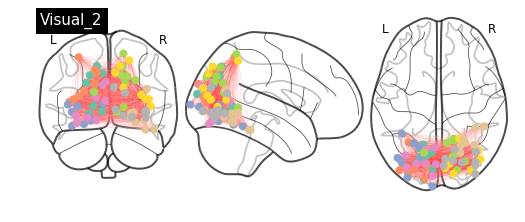

In [26]:
for network in numpy.unique(parceldata.iloc[:,7]):
    adjmtx=meancorrmtx
    # create an adjacency matrix containing only parcels from a specific network
    network_matches=parceldata.iloc[:,7].values==network
    adjmtx=adjmtx[network_matches,:]
    adjmtx=adjmtx[:,network_matches]
    nilearn.plotting.plot_connectome(adjmtx, parceldata.iloc[network_matches,2:5],
                                title=network,
                                edge_kwargs={'linewidth':0.2})


Now let's look at how weights map to the connections within and between these networks.  First we create a function that takes in a set of weights and summarizes them across all combinations of networks.

In [66]:
def parcelmap(weights,parceldata,show_image=True):
    """
    summarize weights by network and plot results
    """
    parcel_networks=parceldata.iloc[:,7].values
    networks=numpy.unique(parcel_networks)
    n_networks=len(networks)
    # create a matrix that defines the networks
    colnetworkmtx=numpy.tile(parcel_networks,(630,1))
    colnetworkmtx[numpy.diag_indices_from(colnetworkmtx)]='none'
    rownetworkmtx=colnetworkmtx.T

    # create full weight matrix from upper triangle
    weight_mtx=mtx_from_utr(weights)

    # summarize weights by networks
    network_mtx=numpy.zeros((n_networks,n_networks))
    for i in range(n_networks):
        for j in range(n_networks):
            match=numpy.where((rownetworkmtx==networks[i]) * (colnetworkmtx==networks[j]))
            matchmtx=weight_mtx[match]
            network_mtx[i,j]=numpy.mean(matchmtx)
            
    if show_image:
        plt.figure(figsize=(8,8))
        plt.imshow(network_mtx)
        plt.colorbar()
        ax=plt.gca()
        ax.set_yticks(numpy.arange(0,14))
        ax.set_yticklabels(networks)
        plt.xticks(numpy.arange(0,14), rotation='vertical')
        ax.set_xticklabels(networks)

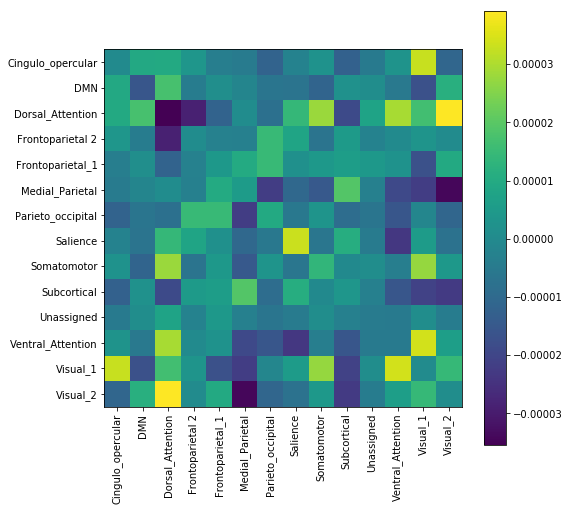

In [67]:
parcelmap(weights,parceldata)

From this we can see that it's the visual and somatomotor networks and their interconnections that are positively predictive of fatigue, and dorsal attention, frontoparietal, and medial parietal networks that are negatively predictive with fatigue.

### Identifying resting state networks

The networks listed above were based on the use of a network clustering (or "community detection") algorithm, which identifies sets of nodes that are more strongly connected with one another than they are with other regions.  There are a number of methods for doing this; we used a method called infomap (code available at https://github.com/mapequation/infomap).  This is implemented within the igraph library.

In [29]:
# what proportion of edges do we want? this is arbitrary.
# use this to find the cutoff for this proportion
density=0.05 
cutoff=scipy.stats.scoreatpercentile(meancorr,100-density*100)

# create binarized adjacency matrix
adjmtx=mtx_from_utr(corrdata)
adjmtx[adjmtx<cutoff]=0
adjmtx[adjmtx>0]=1

# use igraph to generate an undirected graph representation
# of our network
G = igraph.Graph.Adjacency(adjmtx.tolist(),mode='UNDIRECTED')
print('Original graph summary:')
print(G.summary())

# for network analyses we generally only look at the 
# largest connected component of the graph, known as the giant component

# save original community membership to graph variable
parcel_networks=parceldata.iloc[:,7].values
for v in G.vs:
    v['powernetwork']=parcel_networks[v.index]
    
# find giant component
vc = G.components() ##Get VertexClustering object
G_gc=vc.giant()
print('Giant component summary:')
print(G_gc.summary())

Original graph summary:
IGRAPH U--- 630 9907 -- 
Giant component summary:
IGRAPH U--- 566 9889 -- 
+ attr: powernetwork (v)


In [65]:
# use the infomap algorithm to perform community detection
community=G_gc.community_infomap(trials=20)

# save infomap community membership to each node
for v in G_gc.vs:
    v['infomap']=community.membership[v.index]

print(numpy.unique(community.membership))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Let's look at the networks identified using infomap and compare them to the networks identified by Laumann and colleagues (who used a fancier consensus clustering method that combined across different network densities).

In [21]:
for c in numpy.unique(community.membership):
    powernets=[node['powernetwork'] for node in G_gc.vs if node['infomap']==c]
    df=pandas.DataFrame({'OrigNetwork':powernets})
    print('infomap community %d'%c)
    print(df.groupby('OrigNetwork').size().sort_values(ascending=False))
    print('')

infomap community 0
OrigNetwork
Frontoparietal_1    105
Dorsal_Attention      8
Frontoparietal 2      7
DMN                   2
Unassigned            1
dtype: int64

infomap community 1
OrigNetwork
Cingulo_opercular    102
Somatomotor            3
Unassigned             1
Salience               1
Frontoparietal 2       1
Dorsal_Attention       1
dtype: int64

infomap community 2
OrigNetwork
Somatomotor          84
Unassigned            3
Cingulo_opercular     1
dtype: int64

infomap community 3
OrigNetwork
Visual_2             62
Visual_1              2
Somatomotor           2
Parieto_occipital     1
Dorsal_Attention      1
dtype: int64

infomap community 4
OrigNetwork
DMN                  46
Salience             10
Frontoparietal 2      3
Parieto_occipital     2
Frontoparietal_1      1
Cingulo_opercular     1
dtype: int64

infomap community 5
OrigNetwork
Ventral_Attention    22
DMN                   4
Frontoparietal_1      2
Unassigned            1
dtype: int64

infomap community 6
Or

Now let's plot a two-dimensional projection of the data. Here we use a "force-directed" layout generated using the Fruchterman-Reingold algorithm (https://github.com/gephi/gephi/wiki/Fruchterman-Reingold), in which nodes repel each other and edges between nodes result in attraction.

In [27]:
pal = igraph.drawing.colors.ClusterColoringPalette(len(community))
G_gc.vs['color'] = pal.get_many(community.membership)
visual_style = {"vertex_size":8}
igraph.plot(G_gc, layout="fr",**visual_style)

### Characterizing network structure

The structure identified by the infomap algorithm is often referred to as "modular" structure, reflecting the fact that nodes within a module are more strongly connected to one another than they are to nodes in other modules. However, at the same time, the brain also integrates information across modules.  It is this simultaneous presence of modular structure and network-wide integration that characterizes many complex real-world networks.

Let's characterize two aspects of network structure that characterize the tradeof between modular structure and network integration.  *Modularity* characterizes the degree to which members of modules are more strongly connected to each other compared to members of different modules, normalized by what is expected based on a null model of random connectivity.  *Global efficiency* is the inverse of the average shortest path between each pair of nodes, reflecting how easily a message could pass from any node to any other node.



In [217]:
density=0.05  # arbitrary
modularity=numpy.zeros(corrdata.shape[0])
globaleff=numpy.zeros(corrdata.shape[0])

method=''
for session in range(corrdata.shape[0]):
    adjmtx=mtx_from_utr(corrdata[session,:])    
    cutoff=scipy.stats.scoreatpercentile(corrdata[session,:],100-density*100)

    # create binarized adjacency matrix
    adjmtx[adjmtx<cutoff]=0
    adjmtx[adjmtx>0]=1

    # use igraph to generate an undirected graph representation
    # of the network
    Gsess = igraph.Graph.Adjacency(adjmtx.tolist(),mode='UNDIRECTED')
    
    # find giant component
    vc = Gsess.components() 
    Gsess_gc=vc.giant()
    print(Gsess_gc.summary())
    
    # compute community structure
    # here we use a multilevel modularity maximization technique
    community=Gsess_gc.community_multilevel()
    modularity[session]=Gsess_gc.modularity(community.membership)
    geff=1/numpy.array(Gsess_gc.shortest_paths())
    geff[~numpy.isfinite(geff)]=numpy.nan
    globaleff[session]=numpy.nanmean(geff)


IGRAPH U--- 589 9906 -- 


/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


IGRAPH U--- 584 9906 -- 
IGRAPH U--- 597 9907 -- 
IGRAPH U--- 595 9907 -- 
IGRAPH U--- 598 9906 -- 
IGRAPH U--- 602 9903 -- 
IGRAPH U--- 579 9906 -- 
IGRAPH U--- 575 9900 -- 
IGRAPH U--- 593 9906 -- 
IGRAPH U--- 602 9906 -- 
IGRAPH U--- 594 9904 -- 
IGRAPH U--- 591 9899 -- 
IGRAPH U--- 584 9905 -- 
IGRAPH U--- 585 9905 -- 
IGRAPH U--- 590 9904 -- 
IGRAPH U--- 582 9904 -- 
IGRAPH U--- 562 9906 -- 
IGRAPH U--- 602 9906 -- 
IGRAPH U--- 582 9906 -- 
IGRAPH U--- 594 9905 -- 
IGRAPH U--- 594 9905 -- 
IGRAPH U--- 585 9904 -- 
IGRAPH U--- 583 9896 -- 
IGRAPH U--- 575 9901 -- 
IGRAPH U--- 567 9902 -- 
IGRAPH U--- 583 9906 -- 
IGRAPH U--- 591 9905 -- 
IGRAPH U--- 584 9903 -- 
IGRAPH U--- 581 9904 -- 
IGRAPH U--- 565 9895 -- 
IGRAPH U--- 582 9905 -- 
IGRAPH U--- 605 9906 -- 
IGRAPH U--- 589 9904 -- 
IGRAPH U--- 600 9905 -- 
IGRAPH U--- 593 9905 -- 
IGRAPH U--- 577 9902 -- 
IGRAPH U--- 585 9905 -- 
IGRAPH U--- 579 9901 -- 
IGRAPH U--- 583 9906 -- 
IGRAPH U--- 594 9906 -- 
IGRAPH U--- 604 9905 -- 


In Shine et al (2016, PNAS) we performed examined the relation between global efficiency and 

In [218]:
corr_results=pandas.DataFrame(numpy.zeros((behavdata.shape[1],2)))
corr_results.columns=['modularity','global efficiency']
corr_results.index=list(behavdata.columns)
pvals=corr_results.copy()
for Yvar in behavdata.columns:
    goodY=numpy.isfinite(behavdata[Yvar].values)
    Y=behavdata[Yvar].values[goodY]
    corr_results['modularity'][Yvar],pvals['modularity'][Yvar]=scipy.stats.pearsonr(Y,modularity[goodY])
    corr_results['global efficiency'][Yvar],pvals['global efficiency'][Yvar]=scipy.stats.pearsonr(Y,globaleff[goodY])


print('Correlation values')
print(corr_results)
print('P-values (Bonferroni corrected)')
pvals_bonf=pvals*numpy.prod(pvals.shape)
pvals_bonf[pvals_bonf>1]=1
print(pvals_bonf)

Correlation values
                modularity  global efficiency
panas:positive    0.018326           0.276736
panas:negative   -0.110419          -0.160681
panas:fatigue    -0.015643          -0.203026
P-values (Bonferroni corrected)
                modularity  global efficiency
panas:positive         1.0           0.101957
panas:negative         1.0           1.000000
panas:fatigue          1.0           0.496569


Here we don't really see a strong relation between behavior measures and 